# Setup notebook and import data

In [1]:
import pandas as pd
import os
import zipfile

# Data Cleaning

## Narrow that data
- We will focus on these files on the dataset:
    - MNCAATourneyDetailedResults: details stats from past mens tournament games. we will use the previous two seasons as an indicator of how a team will perform in the tourney. Using the past two seasons, becuase the make up of the team (individual players) will not change much in two years.
    - WNCAATourneyDetailedResults: the same information for womens teams.
    - MRegularSeasonDetailedResults: detailed stats for each mens team in the regular season. will limit this data to the 2024 season.
    - WRegularSeasonDetailedResults: same detailed regular season stats for womens teams.
    - 2024_tourney_seeds: starting tournament rankings for both mens and womens teams. a lower seed indicates a stronger team.

- We will limit the teams to 64 mens teams and 64 womens teams because there are only 64 teams invited to play in the end of season tournament. 
- Using these files we will assemble one dataset and limit it to two years of historical performance
- will use the MTeams and WTeams files at the end to map team names to team ID's

In [2]:
# import data
m_reg_season = pd.read_csv('./data/MRegularSeasonDetailedResults.csv')
w_reg_season = pd.read_csv('./data/WRegularSeasonDetailedResults.csv')
m_hist_tourney = pd.read_csv('./data/MNCAATourneyDetailedResults.csv')
w_hist_tourney = pd.read_csv('./data/WNCAATourneyDetailedResults.csv')
tourney_seeds = pd.read_csv('./data/2024_tourney_seeds.csv')
m_teams = pd.read_csv('./data/MTeams.csv')
w_teams = pd.read_csv('./data/WTeams.csv')


### Assemble dataframes into one df for training
- first we will concat the mens and womens data frames into one data frame
- then we will combine the regular season data and historical tournament data.
- the goal is to create a dataframe where a single row is a single game. the label for each row will be a true or false if the team won that particular game.
- adding the tournament seeds for each team will add a feature for training.
- we can also use the seeds to make a baseline estimate of winners. we can simply pick the higher seed for any particular matchup and that will give a goal for the model to beat.

In [3]:
m_reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [4]:
w_reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14


In [5]:
# limit regular season data to only 2024 and then concat the mens and womens data into one df
# m_reg_season = m_reg_season[m_reg_season['Season'] == 2024]
# w_reg_season = w_reg_season[w_reg_season['Season'] == 2024]
reg_season = pd.concat([m_reg_season, w_reg_season], axis=0)


In [6]:
reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


### Do the same for historical tournament data. since we do not have 2024 tournament data, limit this data to the previous two years

In [7]:
# limit tournament data to only 2022 and 2023 and then concat the mens and womens data into one df
m_hist_tourney = m_hist_tourney[m_hist_tourney['Season'] >= 2022]
w_hist_tourney = w_hist_tourney[w_hist_tourney['Season'] >= 2022]
hist_tourney = pd.concat([m_hist_tourney, w_hist_tourney], axis=0)

In [8]:
hist_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
1181,2022,134,1231,66,1461,58,N,0,26,62,...,19,12,18,7,23,6,18,2,1,17
1182,2022,134,1411,76,1394,67,N,0,23,55,...,21,9,19,7,29,17,8,9,3,22
1183,2022,135,1323,89,1353,87,N,2,37,72,...,27,4,6,13,28,22,13,1,6,15
1184,2022,135,1460,93,1136,82,N,0,29,61,...,24,16,23,10,22,7,13,11,5,24
1185,2022,136,1116,75,1436,71,N,0,24,56,...,24,10,17,5,26,13,6,1,1,21


### Combine historical tournament data and 2024 regular season data

In [9]:
data = pd.concat([hist_tourney, reg_season], axis=0)

# add seeds column
data = pd.merge(data, tourney_seeds, left_on='WTeamID', right_on='TeamID', how='left')
data.drop(columns=['Tournament', 'TeamID'], inplace=True) # drop some redundant columns

### Assign "Seed" to teams without one
- if a team does not have a seed it indicates that they were not invited to play in the 2024 tournament.
- these teams may have played in the tournament in previous years, so rather than dropping these rows we will assign a "Seed" of 20. This will indicate that they were not a strong team in 2024.
- Teams that are seeded have a value with a letter followed by a number between 1 and 16. we are only interested in the number so we will trim the letter from seeded teams

In [10]:
data['Seed'] = data['Seed'].fillna('20')
data['Seed'] = data['Seed'].apply(lambda x: x[1:] if len(x) == 3 else x)

# convert to an int
data['Seed'] = data['Seed'].astype('int64')

In [11]:
data['WLoc'].unique()

array(['N', 'H', 'A'], dtype=object)

#### WLoc column
- The 'WLoc' column indicates the location of the game for the winning team (WTeamID).
    - N = neautral location
    - H = home game
    - A = away game
- will need to encode these to a numeric values

In [12]:
# use pandas "get_dummies" method to one hot encode 'WLoc' feature
data = pd.get_dummies(data, columns=['WLoc'])

### Add "IsWin" feature
- In order to add a feature that will be the target (i.e. whether or not the team won the game) we will need to reorganize the data
- assign each row a "gameID" to give each game a unique value
- Split the winner and loser features into seperate dataframes and the rename them to neutral names. for example, instead of "WTeamID" for winning team ID, just TeamID
- Add an "IsWin" column to each df with the appropriate value, and then concat them back together

In [13]:
# add a gameID col
data['gameID'] = range(1, len(data) + 1)

# split data into winners and losers
winner_cols = ['gameID', 'WTeamID', 'WScore', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst',
    'WTO', 'WStl', 'WBlk', 'WPF', 'Seed', 'WLoc_A', 'WLoc_H', 'WLoc_N']

loser_cols = ['gameID', 'LTeamID', 'LScore', 'NumOT', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst',
    'LTO', 'LStl', 'LBlk', 'LPF', 'Seed', 'WLoc_A', 'WLoc_H', 'WLoc_N']

winners = data[winner_cols]
loosers = data[loser_cols]

In [14]:
# rename columns to neutral names
winners = winners.rename(columns={'WTeamID': 'TeamID', 'WScore': 'Score', 'WFGM': 'FGM', 'WFGA': 'FGA', 'WFGM3': 'FGM3',
    'WFGA3': 'FGA3', 'WFTM': 'FTM', 'WFTA': 'FTA', 'WOR': 'OR', 'WDR': 'DR', 'WAst': 'Ast', 'WTO': 'TO', 'WStl': 'Stl', 'WBlk': 'Blk',
    'WPF': 'PF', 'WLoc_A': 'Loc_A', 'WLoc_H': 'Loc_H', 'WLoc_N': 'Loc_N'})

loosers = loosers.rename(columns={'LTeamID': 'TeamID', 'LScore': 'Score', 'LFGM': 'FGM', 'LFGA': 'FGA', 'LFGM3': 'FGM3', 'LFGA3': 'FGA3',
    'LFTM': 'FTM', 'LFTA': 'FTA', 'LOR': 'OR', 'LDR': 'DR', 'LAst': 'Ast', 'LTO': 'TO', 'LStl': 'Stl', 'LBlk': 'Blk', 'LPF': 'PF', 'WLoc_A': 'Loc_A',
    'WLoc_H': 'Loc_H', 'WLoc_N': 'Loc_N' })

In [15]:
# add "IsWin" column with appropriate value
winners['IsWin'] = True
loosers['IsWin'] = False

# for loosers flip the value of the location columns

# temporarily split the neutral games out
neutral = loosers[loosers['Loc_N'] == True]
loosers = loosers[loosers['Loc_N'] == False]

# flip values
loosers['Loc_A'] = ~loosers['Loc_A']
loosers['Loc_H'] = ~loosers['Loc_H']

# concat neutral games back in
loosers = pd.concat([loosers, neutral], axis=0)

### Add opponent stats columns
- concat winners and loosers back together width wise and rename the columns to indicate they are opponent game stats
- combine winners and loosers back together vertically

In [16]:
winner_opponent = loosers.add_prefix('opp_')
loser_opponent = winners.add_prefix('opp_')

winners = pd.concat([winners, loser_opponent], axis=1)
loosers = pd.concat([loosers, winner_opponent], axis=1)

data = pd.concat([winners, loosers], axis=0)

# drop redundant columns
data.drop(columns=['opp_gameID', 'opp_Loc_A', 'opp_Loc_H', 'opp_Loc_N', 'opp_IsWin'], inplace=True)

In [17]:
# drop opp_NumOT since it is redundanct
del data['opp_NumOT']

In [18]:
data.to_csv('prepared_data.csv', index=False)

In [19]:
data = pd.read_csv('./prepared_data.csv')

In [20]:
data.columns

Index(['gameID', 'TeamID', 'Score', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3',
       'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'Seed',
       'Loc_A', 'Loc_H', 'Loc_N', 'IsWin', 'opp_TeamID', 'opp_Score',
       'opp_FGM', 'opp_FGA', 'opp_FGM3', 'opp_FGA3', 'opp_FTM', 'opp_FTA',
       'opp_OR', 'opp_DR', 'opp_Ast', 'opp_TO', 'opp_Stl', 'opp_Blk', 'opp_PF',
       'opp_Seed'],
      dtype='object')

In [21]:
data.head()

,gameID,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,...,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,opp_Seed
0,1,1231,66,0,26,62,2,13,12,20,...,12,20,12,22,10,7,3,3,22,20
1,2,1411,76,0,23,55,4,13,26,35,...,26,35,8,34,9,15,4,9,18,20
2,3,1323,89,2,37,72,6,19,9,16,...,9,16,7,22,17,5,6,2,8,20
3,4,1460,93,0,29,61,9,21,26,32,...,26,32,12,29,19,15,6,4,20,20
4,5,1116,75,0,24,56,7,21,20,25,...,20,25,5,30,12,5,2,3,19,20


#### Create aggregate data for each team
- in order to predict one teams performace against another, we will create some data aggregations for each team. i.e. average score, winning percentage, and averages or medians of other game stats.
- In the final product, the user will be asked to enter two teams and the model will use these aggregated stats for those teams as inputs to make a prediction of which team will win

In [22]:
# split data aggregations into home, away and neutral location games
neutral_games = data[data['Loc_N'] == True]
home_games = data[data['Loc_H'] == True]
away_games = data[data['Loc_A'] == True]

In [23]:
# perform aggregations for each team
neutral_games = neutral_games.groupby('TeamID').agg({
    'Score': 'mean',   # Average score
    'FGM': 'mean',     # Average field goals made
    'FGA': 'mean',     # Average field goals attempted
    'FGM3': 'mean',    # Average three-point field goals made
    'FGA3': 'mean',    # Average three-point field goals attempted
    'FTM': 'mean',     # Average free throws made
    'FTA': 'mean',     # Average free throws attempted
    'OR': 'mean',      # Average offensive rebounds
    'DR': 'mean',      # Average defensive rebounds
    'Ast': 'mean',     # Average assists
    'TO': 'mean',      # Average turnovers
    'Stl': 'mean',     # Average steals
    'Blk': 'mean',     # Average blocks
    'PF': 'mean'       # Average personal fouls
}).reset_index()

home_games = home_games.groupby('TeamID').agg({
    'Score': 'mean',
    'FGM': 'mean',
    'FGA': 'mean',
    'FGM3': 'mean',
    'FGA3': 'mean',
    'FTM': 'mean',
    'FTA': 'mean',
    'OR': 'mean',
    'DR': 'mean',
    'Ast': 'mean',
    'TO': 'mean',
    'Stl': 'mean',
    'Blk': 'mean',
    'PF': 'mean'
}).reset_index()

away_games = away_games.groupby('TeamID').agg({
    'Score': 'mean',
    'FGM': 'mean',
    'FGA': 'mean',
    'FGM3': 'mean',
    'FGA3': 'mean',
    'FTM': 'mean',
    'FTA': 'mean',
    'OR': 'mean',
    'DR': 'mean',
    'Ast': 'mean',
    'TO': 'mean',
    'Stl': 'mean',
    'Blk': 'mean',
    'PF': 'mean'
}).reset_index()

neutral_games.to_csv('neutral_game_aggregations.csv', index=False)
home_games.to_csv('home_game_aggregations.csv', index=False)
away_games.to_csv('away_game_aggregations.csv', index=False)

# Data Exploration

In [24]:
# there are two rows for each game. one for each team
data.sort_values(by='gameID').head()

,gameID,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,...,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,opp_Seed
0,1,1231,66,0,26,62,2,13,12,20,...,12,20,12,22,10,7,3,3,22,20
360783,1,1461,58,0,20,46,6,19,12,18,...,12,18,7,23,6,18,2,1,17,20
360784,2,1394,67,0,25,67,8,21,9,19,...,9,19,7,29,17,8,9,3,22,20
1,2,1411,76,0,23,55,4,13,26,35,...,26,35,8,34,9,15,4,9,18,20
2,3,1323,89,2,37,72,6,19,9,16,...,9,16,7,22,17,5,6,2,8,20


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379412 entries, 0 to 379411
Data columns (total 38 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   gameID      379412 non-null  int64
 1   TeamID      379412 non-null  int64
 2   Score       379412 non-null  int64
 3   NumOT       379412 non-null  int64
 4   FGM         379412 non-null  int64
 5   FGA         379412 non-null  int64
 6   FGM3        379412 non-null  int64
 7   FGA3        379412 non-null  int64
 8   FTM         379412 non-null  int64
 9   FTA         379412 non-null  int64
 10  OR          379412 non-null  int64
 11  DR          379412 non-null  int64
 12  Ast         379412 non-null  int64
 13  TO          379412 non-null  int64
 14  Stl         379412 non-null  int64
 15  Blk         379412 non-null  int64
 16  PF          379412 non-null  int64
 17  Seed        379412 non-null  int64
 18  Loc_A       379412 non-null  bool 
 19  Loc_H       379412 non-null  bool 
 20  Loc_

In [26]:
data.describe()

,gameID,TeamID,Score,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,...,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,opp_Seed
count,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,...,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000
mean,94853.500000,2090.222966,67.622358,0.062006,24.071592,57.139194,6.280455,18.911234,13.198718,18.914199,...,13.198718,18.914199,11.040080,24.063351,13.003411,14.442345,7.040652,3.298412,17.538491,17.176325
std,54763.477252,986.398125,13.090046,0.288116,5.088440,7.811214,3.045504,6.299677,5.959489,7.783689,...,5.959489,7.783689,4.454167,5.321168,4.525426,4.810870,3.298698,2.287286,5.028960,5.578954
min,1.000000,1101.000000,11.000000,0.000000,3.000000,25.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,47427.000000,1256.000000,59.000000,0.000000,21.000000,52.000000,4.000000,15.000000,9.000000,13.000000,...,9.000000,13.000000,8.000000,20.000000,10.000000,11.000000,5.000000,2.000000,15.000000,20.000000
50%,94853.500000,1407.000000,67.000000,0.000000,24.000000,57.000000,6.000000,19.000000,13.000000,18.000000,...,13.000000,18.000000,11.000000,24.000000,13.000000,14.000000,7.000000,3.000000,18.000000,20.000000
75%,142280.000000,3242.000000,76.000000,0.000000,27.000000,62.000000,8.000000,23.000000,17.000000,24.000000,...,17.000000,24.000000,14.000000,28.000000,16.000000,17.000000,9.000000,5.000000,21.000000,20.000000
max,189706.000000,3478.000000,149.000000,6.000000,58.000000,113.000000,26.000000,80.000000,50.000000,67.000000,...,50.000000,67.000000,45.000000,58.000000,45.000000,49.000000,36.000000,21.000000,47.000000,20.000000


#### Column info
- gameID: unique id for each game. there will be two rows for each id. one for each team
- TeamID: id to identify each team
- Score: teams score for that game
- NumOT: if the game went into overtime, this number indicates the number of overtime periods played
- FGM: field goals made
- FGA: field goals attempted
- FGM3: 3-point field goals made
- FGA3: 3-point field goals attempted
- FTM: free throws made
- FTA: free throws attempted
- OR: offensive rebounds
- DR: defensive rebounds
- Ast: assists
- TO: turn overs
- Stl: steals
- Blk: blocks
- PF: total personal fouls commited by the team in that game
- Seed: the teams seed in the 2024 NCAA tourney. if the team was not invited to the 2024 tournament a seed of 20 was assigned to indicate a weaker team
- Loc_A: if the location the game was away
- Loc_H: if the location the game was home
- Loc_N: if the location the game was neutral
- IsWin: team won the game
- opp_TeamID: opponents teamID
- opp_Score: opponents score
- opp_FGM: opponent field goals made
- opp_FGA: opponent field goals attempted
- opp_FGM3: opponent 3-point field goals made
- opp_FGA3: opponent 3-point field goals attempted
- opp_FTM: opponent free throws made
- opp_FTA: opponent free throws attempted
- opp_OR: opponent offensive rebounds
- opp_DR: opponent defensive rebounds
- opp_Ast: opponent assists
- opp_TO: opponent turn overs
- opp_Stl: opponent steals
- opp_Blk: opponent blocks
- opp_PF: opponent total personal fouls commited in that game
- opp_Seed: opponent seed

#### Visualization

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# selected features
features = [
    # 'gameID',
    # 'TeamID',
    'Score',
    # 'NumOT',
    'FGM',
    'FGA',
    'FGM3',
    'FGA3',
    'FTM',
    'FTA',
    'OR',
    'DR',
    'Ast',
    'TO',
    'Stl',
    'Blk',
    'PF',
    # 'mens_data',
    # 'tourney_game',
    'Seed',
    'Loc_A',
    'Loc_H',
    'Loc_N',
    'IsWin',
    # 'opp_TeamID',
    'opp_Score',
    'opp_FGM',
    'opp_FGA',
    'opp_FGM3',
    'opp_FGA3',
    'opp_FTM',
    'opp_FTA',
    'opp_OR',
    'opp_DR',
    'opp_Ast',
    'opp_TO',
    'opp_Stl',
    'opp_Blk',
    'opp_PF',
    'opp_Seed'
    ]

In [28]:
data[features].head()

,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,...,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,opp_Seed
0,66,26,62,2,13,12,20,12,22,10,...,12,20,12,22,10,7,3,3,22,20
1,76,23,55,4,13,26,35,8,34,9,...,26,35,8,34,9,15,4,9,18,20
2,89,37,72,6,19,9,16,7,22,17,...,9,16,7,22,17,5,6,2,8,20
3,93,29,61,9,21,26,32,12,29,19,...,26,32,12,29,19,15,6,4,20,20
4,75,24,56,7,21,20,25,5,30,12,...,20,25,5,30,12,5,2,3,19,20


In [29]:
neutral_games.shape

(728, 15)

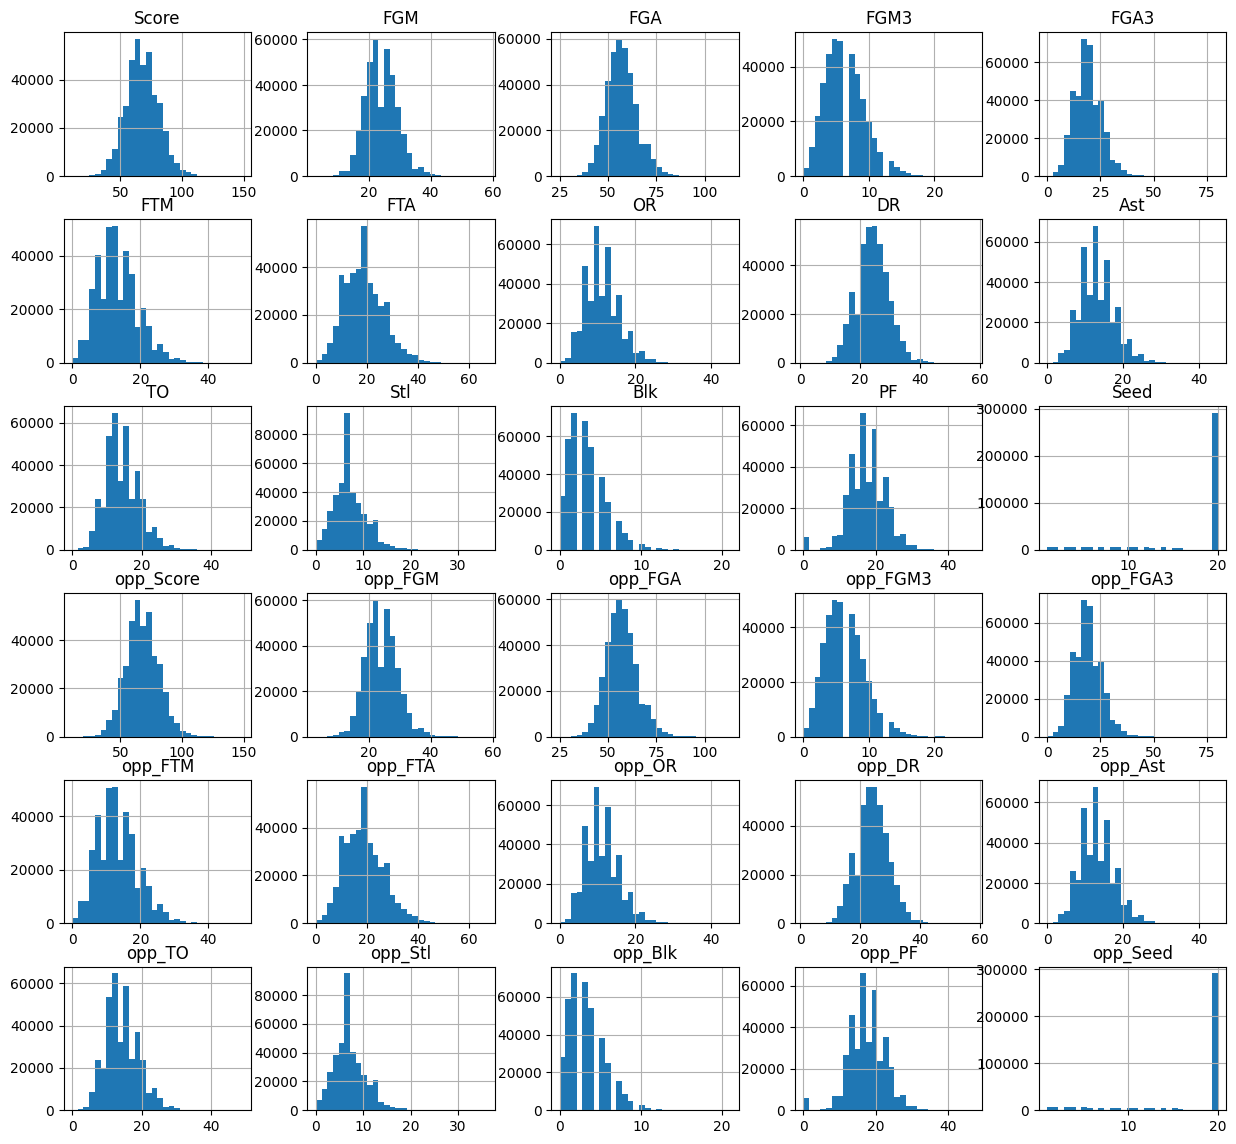

In [30]:
# histogram
data[features].hist(bins=30, figsize=(15, 14))
plt.show()

In [31]:
# create correlation matrix
correlation_matrix = data.corr()
correlation_matrix['IsWin'].sort_values(ascending=False)

IsWin         1.000000e+00
Score         4.943435e-01
opp_Score     4.943435e-01
opp_FGM       4.049279e-01
FGM           4.049279e-01
opp_Ast       3.949194e-01
Ast           3.949194e-01
opp_DR        3.862941e-01
DR            3.862941e-01
FTM           2.945250e-01
opp_FTM       2.945250e-01
FTA           2.647130e-01
opp_FTA       2.647130e-01
Loc_H         2.457398e-01
FGM3          1.953234e-01
opp_FGM3      1.953234e-01
opp_Blk       1.942689e-01
Blk           1.942689e-01
opp_Stl       1.805565e-01
Stl           1.805565e-01
opp_OR        2.491831e-02
OR            2.491831e-02
opp_TeamID    1.330984e-03
TeamID        1.330984e-03
opp_Seed      3.329820e-14
Seed          3.328390e-14
Loc_N         4.532600e-15
NumOT         2.078624e-15
gameID       -1.227737e-14
FGA          -1.822271e-02
opp_FGA      -1.822271e-02
FGA3         -4.134057e-02
opp_FGA3     -4.134057e-02
TO           -1.684058e-01
opp_TO       -1.684058e-01
opp_PF       -2.125023e-01
PF           -2.125023e-01
L

#### Stats correlated with winning games
- Highly correlated:
    - Score (duh)
    - Field goals made
    - Assists
    - Defensive rebounds
- Somewhat correlated:
    - Free throws made
    - 3-point field goals made
    - If the game was played at home
- Low correlation:
    - Steals
    - Blocks
    - Offensive rebounds (this is surprising since offensive rebounds grant a team an extra offensive possision and another opportunity to score)
- Negative correlations (detrimental to winning the game):
    - Turnovers
    - Personal Fouls
    - If the game was played away

- Opponent stat correlations mirror these. i.e. an opponent that has a lot of field goals made is detrimental to winning the game
- This gives a good idea of which features to focus on

# Model Selection

## Split and scale the data

In [32]:
# set a random state
rand_state = 54

In [33]:
# split target from data
X = data.copy()
X.drop(columns=[
    'IsWin',
    'gameID',
    'NumOT',
    'Seed',
    'opp_Seed',
], inplace=True)
y = data['IsWin']

In [34]:
import numpy as np
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble, naive_bayes
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

In [145]:
# store training data. will be used in the app later
X.to_csv('./training_data.csv', index=False)

In [89]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Test some models and their accuracy on the data

In [36]:
def evaluate_classifier(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    # Print the metrics
    print(f"{model.__class__.__name__}:")
    print(f"Accuracy = {accuracy:.4f}")
    print("-"*100)

In [37]:
models = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    RidgeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    xgboost.XGBClassifier(),
    SGDClassifier(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(algorithm='SAMME'),
]

for model in models:
    evaluate_classifier(model, X_train_scaled, X_test_scaled, y_train, y_test)

LogisticRegression:
Accuracy = 0.8780
----------------------------------------------------------------------------------------------------
KNeighborsClassifier:
Accuracy = 0.8303
----------------------------------------------------------------------------------------------------
RidgeClassifier:
Accuracy = 0.8773
----------------------------------------------------------------------------------------------------
RandomForestClassifier:
Accuracy = 0.8544
----------------------------------------------------------------------------------------------------
GradientBoostingClassifier:
Accuracy = 0.8559
----------------------------------------------------------------------------------------------------
XGBClassifier:
Accuracy = 0.8755
----------------------------------------------------------------------------------------------------
SGDClassifier:
Accuracy = 0.8715
----------------------------------------------------------------------------------------------------
DecisionTreeClassifier:
Ac

### Initial results
- Best performing models are LogisticRegression, RidgeClassifier and XGBClassifier
- will try to reduce dimensions and see how it affects the results

In [38]:
from sklearn.decomposition import PCA

# reduce to the number of dimensions that will contain 95% of the variance of the data
pca = PCA(n_components=0.95)

X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=rand_state)

In [39]:
models = [
    LogisticRegression(max_iter=1000),
    RidgeClassifier(),
    RandomForestClassifier(),
    xgboost.XGBClassifier(),
]

for model in models:
    evaluate_classifier(model, X_train_pca, X_test_pca, y_train, y_test)

LogisticRegression:
Accuracy = 0.4998
----------------------------------------------------------------------------------------------------
RidgeClassifier:
Accuracy = 0.4998
----------------------------------------------------------------------------------------------------
RandomForestClassifier:
Accuracy = 0.6510
----------------------------------------------------------------------------------------------------
XGBClassifier:
Accuracy = 0.5542
----------------------------------------------------------------------------------------------------


### Ineffective dimensionality reduction
- using pca reduction significantly reduced accuracy

### Ensemble models

In [40]:
# create a list of ensemble classifier models to try
classifier_models = [
    (ensemble.BaggingClassifier(estimator=LogisticRegression(random_state=rand_state, max_iter=1000), n_estimators=20), 'BaggingClassifier'),
    (ensemble.RandomForestClassifier(random_state=rand_state), 'RandomForestClassifier'),
    (ensemble.ExtraTreesClassifier(random_state=rand_state), 'ExtraTreesClassifier'),
    (ensemble.AdaBoostClassifier(algorithm='SAMME', random_state=rand_state), 'AdaBoostClassifier'),
    (ensemble.GradientBoostingClassifier(random_state=rand_state), 'GradientBoostingClassifier'),
    (ensemble.HistGradientBoostingClassifier(random_state=rand_state), 'HistGradientBoostingClassifier'),
    (xgboost.XGBClassifier(random_state=rand_state), 'XGBoostClassifer')
]

In [41]:
for model, name in classifier_models:
    evaluate_classifier(model, X_train_scaled, X_test_scaled, y_train, y_test)

BaggingClassifier:
Accuracy = 0.8780
----------------------------------------------------------------------------------------------------
RandomForestClassifier:
Accuracy = 0.8551
----------------------------------------------------------------------------------------------------
ExtraTreesClassifier:
Accuracy = 0.8469
----------------------------------------------------------------------------------------------------
AdaBoostClassifier:
Accuracy = 0.8401
----------------------------------------------------------------------------------------------------
GradientBoostingClassifier:
Accuracy = 0.8559
----------------------------------------------------------------------------------------------------
HistGradientBoostingClassifier:
Accuracy = 0.8717
----------------------------------------------------------------------------------------------------
XGBClassifier:
Accuracy = 0.8755
----------------------------------------------------------------------------------------------------


### Voting Classifer

In [43]:
clf1 = ensemble.BaggingClassifier(estimator=LogisticRegression(random_state=rand_state))
clf2 = naive_bayes.GaussianNB()
clf3 = ensemble.HistGradientBoostingClassifier(random_state=rand_state)
clf4 = ensemble.GradientBoostingClassifier(random_state=rand_state)
clf5 = xgboost.XGBClassifier(random_state=rand_state)

estimators = [
    ('bagging', clf1),
    ('naive_bayes', clf2),
    ('HistGradient', clf3),
    ('GrandientBoost', clf4),
    ('XGBoost', clf5)
]

voting_classifier = ensemble.VotingClassifier(estimators=estimators)
voting_classifier.fit(X_train_scaled, y_train)

yclassifier_pred = voting_classifier.predict(X_test_scaled)

accuracy = metrics.accuracy_score(y_test, yclassifier_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8736871235981709


## Results
#### Initial models
- LogisticRegression: Accuracy = 0.8780

### After PCA dimensionality reduction
- RandomForestClassifier: Accuracy = 0.6510

### Ensemble classification models
- BaggingClassifier: Accuracy = 0.8780

### Ensemble Voting Classifiction model
- Accuracy = 0.8736871235981709

# Fine Tuning
- After initial testing, the LogistRegression, BaggingClassifier and Voting Classifier all have nearly the same performance.
- will fine tune each of the models and compare

In [45]:
from sklearn.model_selection import GridSearchCV

# fine tune logistic regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver='saga', random_state=rand_state), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best cross-validation score: 0.88


In [47]:
best_logReg = grid_search.best_estimator_
y_pred = best_logReg.predict(X_test_scaled)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8779568546314721


In [52]:
# fine tune bagging classifier
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
}

grid_search = GridSearchCV(
    ensemble.BaggingClassifier(estimator=LogisticRegression(
        max_iter=1000,
        C=0.1,
        penalty='l2',
        solver='saga',
        random_state=rand_state
    ),
    random_state=rand_state),
    param_grid,
    cv=3,
    n_jobs=-1
    )
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

best_bagging_clf = grid_search.best_estimator_
y_pred = best_bagging_clf.predict(X_test_scaled)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Best parameters: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
Best cross-validation score: 0.88
Test Accuracy: 0.8781149928178907


### Find best hyper parameters for the Gradient boosting classifier, HistGradientBoostingClassifier and XGBClassifier

In [54]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [20, 40, 60]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(ensemble.HistGradientBoostingClassifier(random_state=rand_state), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 300, 'min_samples_leaf': 60}
Best cross-validation score: 0.88
Test Accuracy: 0.8778646073560613


In [60]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(GradientBoostingClassifier(random_state=rand_state), param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model
best_gradientboost_clf = grid_search.best_estimator_
y_pred = best_gradientboost_clf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.88
Test Accuracy: 0.8755716036529921


# Train and Export Final model

In [62]:
# best params for each model
best_logReg_params = {'C': 0.1, 'penalty': 'l2'}
best_bagging_clf_params = {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 20}
best_histGradient_clf_params = {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 300, 'min_samples_leaf': 60}
best_gradientBoost_params = {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

In [66]:
clf1 = ensemble.BaggingClassifier(estimator=LogisticRegression(**best_logReg_params, random_state=rand_state), **best_bagging_clf_params)
clf2 = LogisticRegression(**best_logReg_params, random_state=rand_state)
clf3 = ensemble.HistGradientBoostingClassifier(**best_histGradient_clf_params, random_state=rand_state)
clf4 = ensemble.GradientBoostingClassifier(**best_gradientBoost_params, random_state=rand_state)
clf5 = xgboost.XGBClassifier(random_state=rand_state)

In [71]:
# fine tune voting classifier
estimators = [
    ('bagging', clf1),
    ('logReg', clf2),
    ('HistGradient', clf3),
    ('GrandientBoost', clf4),
    ('XGBoost', clf5)
]

# Create the VotingClassifier
voting_classifier = ensemble.VotingClassifier(estimators=estimators, voting='soft')

# Use the best estimator to make predictions
voting_classifier.fit(X_train_scaled, y_train)
y_pred = voting_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8799072255973011


In [98]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[33469  4491]
 [ 4622 33301]]


## Save the trained model

In [74]:
from joblib import dump, load

In [75]:
# Save the model to a file
dump(voting_classifier, 'voting_classifier.pkl')

['voting_classifier.pkl']

In [76]:
# Load the model from the file
model = load('voting_classifier.pkl')

In [87]:
def create_game_helper(teamID_1, teamID_2):
    """ helper function to add the two selected teams agg stats into in DF """
    # select two teams and concat them into on df. then add the 'Loc_A', 'Loc_H', 'Loc_N' columns
    predict_game = neutral_games[neutral_games['TeamID'] == teamID_1].reset_index(drop=True)
    team2 = neutral_games[neutral_games['TeamID'] == teamID_2].reset_index(drop=True)

    # for team2 drop the teamID and add prefix for columns
    team2 = team2.add_prefix('opp_')

    # predict_game = pd.concat([team1, team2], axis=1)
    for col in team2.columns:
        predict_game[col] = team2[col]

    # add location columns
    predict_game['Loc_A'] = False
    predict_game['Loc_H'] = False
    predict_game['Loc_N'] = True

    # reorder columns to match training data
    predict_game = predict_game[[
        'TeamID','Score','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl',
        'Blk','PF','Loc_A','Loc_H','Loc_N','opp_TeamID','opp_Score','opp_FGM','opp_FGA','opp_FGM3',
        'opp_FGA3','opp_FTM','opp_FTA','opp_OR','opp_DR','opp_Ast','opp_TO','opp_Stl','opp_Blk','opp_PF'
    ]]

    return predict_game

### Scaling
- scaling a dataframe with a single row causes issues. to solve this, fit the scaler on the training data and the use the transform method on the single row dataframe

In [143]:
create_game = create_game_helper(1101, 1373)
created_game_scaled = scaler.transform(create_game)

prediction = model.predict(created_game_scaled)
prediction

array([False])

array([ True])